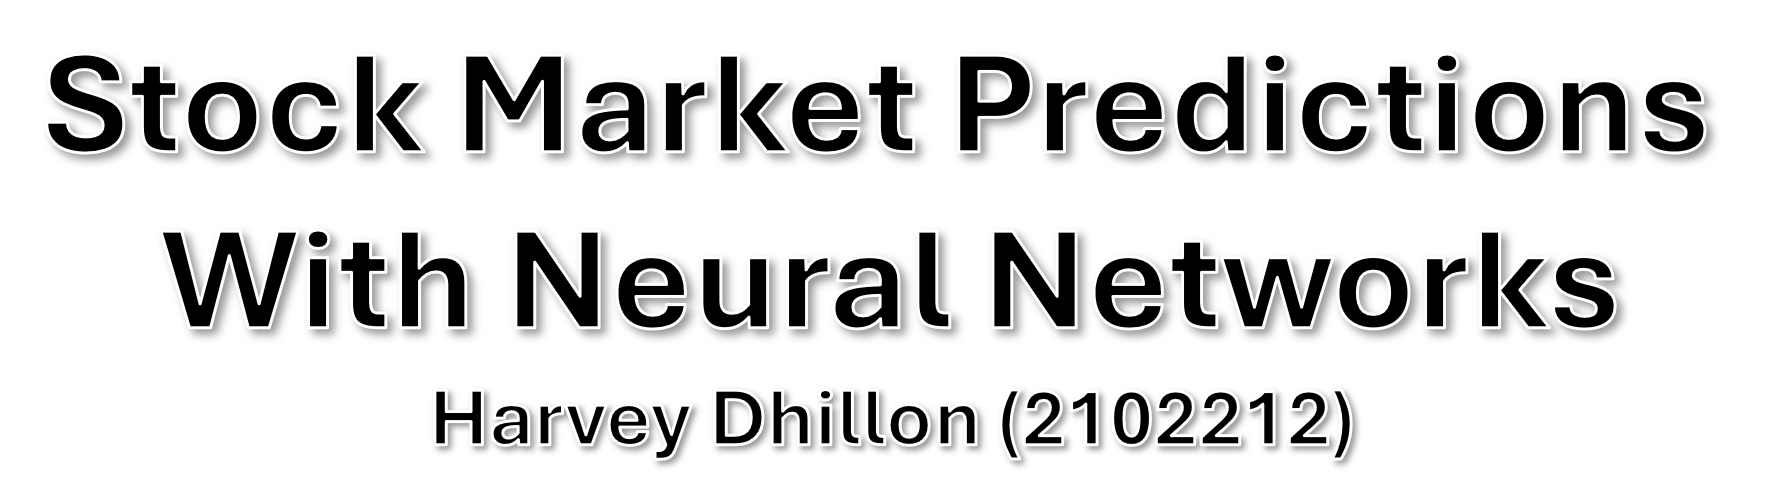

This notebook contains the code to the project document **SUMMARY u2102212.pdf**. For a more holistic explanation of what the targets and aims of this project are, please refer to that document.

# Libraries and Set Seed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow.keras.backend as K
import datetime
import random
import yfinance as yf

Here, we import all the necessary libraries for this code. Here is a breakdown of each library:

1. **numpy (np)**: Used for numerical calculations, array manipulation and data normalisation.

2. **matplotlib.pyplot (plt)**: Used to graph plots for stock trends and mean squared error.

3. **tensorflow.keras.models.Sequential**: Simplifies creating models for CNN sentiment analysis and LSTM price prediction.

4. **tensorflow.keras.layers**:
   - **Dense**: Fully connected layers designed for extracting features.
   - **Embedding**: Converts tokens into dense vector representations.
   - **Conv1D/MaxPooling1D**: Extracts patterns in sequential data.
   - **Flatten**: Converts multidimensional outputs into 1 dimensional arrays.
   - **Dropout**: Reduces overfitting during training.
   - **LSTM/Bidirectional**: Captures dependencies in time series data.

5. **tensorflow.keras.preprocessing.sequence.pad_sequences**: Forces uniform input sequence lengths.

6. **tensorflow.keras.preprocessing.text.Tokenizer**: Converts text into tokens for preprocessing tweets.

7. **tensorflow.keras.optimizers.Adam**: Optimises models with changing learning rates for faster convergence and better accuracy.

8. **tensorflow.keras.callbacks**:
   - **EarlyStopping**: Stops training when validation loss stops improving for a set amount of epochs.
   - **LearningRateScheduler**: Adjusts learning rates during training.

9. **sklearn.preprocessing.MinMaxScaler**: Scales data to a range of [0, 1] for machine learning models.

10. **sklearn.utils.class_weight.compute_class_weight**: Balances imbalanced datasets by calculating class weights.

11. **tensorflow.keras.backend (K)**: Provides low level tensor operations for custom loss functions.

12. **datetime**: Handles date and time operations for stock market analysis.

13. **random**: Generates randomness for synthetic tweet generation and random sampling.

14. **yfinance (yf)**: Retrieves financial data including stock prices and historical trends.



In [ ]:
np.random.seed(1) # Set random seed to 1 for consistency

Here, we set the seed to 1 so all results are the same each time the program is run.

# Sentiment Analysis

In this section we will be performing sentiment analysis on synthetically generated tweets to determine future stock prices.

##**Tweet Templates**

In [ ]:
# Positive tweet templates with number of days placeholder
positiveTemplates = [
    "This stock is going to rise in {} days {}",
    "Analysts expect this stock to improve in {} days {}",
    "Great things are expected from this stock in {} days {}",
    "Buyers are gaining confidence, {} days to a rise {}",
    "Growth predicted for this stock in {} days {}",
    "Expect gains in {} days for this stock {}",
    "Momentum is picking up, {} days to a rise {}",
    "Stock prices set to climb in {} days {}",
    "Positive outlook for this stock in {} days {}",
    "Investors optimistic {} days to improvement {}",
    "Stock rising in {} days {}",
    "Growth in {} days {}",
    "This stock is expected to skyrocket in {} days {}",
    "Brace yourself for gains in {} days for this stock {}",
    "The market forecasts a surge in this stock in {} days {}",
    "Buyers are eyeing profits in {} days {}",
    "Confidence is building gains likely in {} days {}",
    "This stock shows strong upward momentum, {} days to an increase {}",
    "Market sentiment indicates growth in {} days {}",
    "This stock is gaining traction, {} days to a climb {}",
    "Positive trends suggest gains in {} days {}",
    "Investors are boosting this stock, growth in {} days {}",
    "Market indicators predict a rise in {} days {}",
    "Positive movement expected in {} days {}",
    "Prepare for growth, this stock is set to climb in {} days {}",
    "Buy signals strong, {} days to a peak {}",
    "All signs point to upward movement in {} days {}",
    "Stock's upward trend continues, gains predicted in {} days {}",
    "Positive momentum confirmed, {} days to a rise {}",
    "Analysts agree {} days to a positive shift in price {}",
    "Exciting times ahead, growth predicted in {} days {}",
    "This stock is on track for a boost in {} days {}",
    "Momentum surging expect gains in {} days {}",
    "Growth potential is high, {} days to a rise {}",
    "Optimistic that this stock will rise in {} days {}",
    "Expect this stock to perform well in {} days {}",
    "Positive performance likely in {} days {}"]

# Negative tweet templates with number of days placeholder
negativeTemplates = [
    "This stock might drop in {} days {}",
    "Investors fear losses in {} days {}",
    "Market indicates this stock may fall in {} days {}",
    "Potential downturn expected in {} days {}",
    "Decline likely in {} days {}",
    "Investors losing confidence, {} days to a fall {}",
    "Possible sell off incoming in {} days {}",
    "Caution advised, {} days to a drop {}",
    "Risk of losses in {} days for this stock {}",
    "Stock dropping in {} days {}",
    "Decline in {} days {}",
    "Market trends suggest a fall in {} days {}",
    "Negative momentum building, {} days to a decline {}",
    "Prices expected to drop in {} days {}",
    "Confidence is waning, {} days to a fall {}",
    "Analysts warn of losses in {} days {}",
    "Investors are cautious decline predicted in {} days {}",
    "Sell signals strong, {} days to a drop {}",
    "Downward trend observed, {} days to a fall {}",
    "Caution prices may fall in {} days {}",
    "Market pessimistic, {} days to a decline {}",
    "Headwinds expected, {} days to a drop {}",
    "This stock could take a hit in {} days {}",
    "Losses anticipated in {} days {}",
    "Brace for a dip, {} days to a decline {}",
    "Volatility indicates a drop in {} days {}",
    "Stock losing ground, {} days to a fall {}"]

Here are some positive and negative tweet templates, with a placeholder for timestamps. The synthetic tweet generation step will take a random template and predict whether the stock is on the rise or falling at a future timepoint using data. Unfortunately, we cannot use real tweets since the APIs would require payment, so for the purposes of this project, we will synthesise them via the above templates.

##**Stock** **Data**

In [ ]:
# Download historical stock data for chosen stock using yfinance
stockData = yf.download('GOOG', start='2018-01-01', end='2024-12-29') # Google stock data since 2018

# Get the closing prices for analysis
closingPrices = stockData['Close'].values

# Get the timestamps for reference
timeStamps = stockData.index.to_pydatetime()

# Normalize closing prices between 0 and 1
priceScaler = MinMaxScaler(feature_range=(0, 1))
normalizedPrices = priceScaler.fit_transform(closingPrices.reshape(-1, 1)).flatten()  # Flatten for compatibility

# Split the data into training and future prediction sets
splitIndex = int(len(closingPrices) * 0.75)  # Use 75% of data for training
trainingPrices = normalizedPrices[:splitIndex]  # Training data (normalized)
futurePrices = normalizedPrices[splitIndex:]  # Future prices for prediction

[*********************100%***********************]  1 of 1 completed


To preprocess the stock market data, we begin by downloading historical stock data. Using the `yfinance` library, we fetch data for Google's stock (`#GOOG`) from 1st January 2018 to 29th December 2024. From this dataset, the `Close` prices are extracted as the primary feature for analysis and stored as `closingPrices`, while the corresponding times are saved as datetimes in `timeStamps`.

Next, a `MinMaxScaler` is used to scale the closing prices to a range between 0 and 1, normalising the values and ensuring uniformity for neural network training. The `fit_transform` method is applied to scale the prices, and the resulting values are flattened, so they are compatible with subsequent operations, and stored in `normalizedPrices`.

Finally, the dataset is divided into training and future sets. We select the index that splits the first 75% of the total data length from the last 25%. The first 75% of the data is assigned to `trainingPrices` for model training, while the remaining 25% is used as `futurePrices` for validation - we will be predicting this after training the neural network to see how accurately it performs.

##**Synthetic Tweet** **Generation**

In [ ]:
# Initialize empty list for generated tweets, metadata
tweetData = []

# Probability to flip sentiment for randomness
flipSentimentProbability = 0.25  # 25% chance to change sentiment

# Loop through each day up to the split index
for day in range(1, splitIndex):
    for _ in range(25):  # Generate 25 tweets per day
        timeFrame = random.randint(1, len(closingPrices) - splitIndex)  # Choose random time frame for future prediction
        futureDay = day + timeFrame  # Compute the future day timestamp

        if futureDay < len(closingPrices):  # Ensure future day is within valid range
            # Compute price gradient between current day and future day
            gradient = (closingPrices[futureDay] - closingPrices[day]) / timeFrame
            # Choose sentiment: 1 for positive gradient, otherwise 0
            sentiment = 1 if gradient > 0 else 0

            # Flip sentiment randomly based on defined probability
            if random.random() < flipSentimentProbability:
                sentiment = 1 - sentiment  # Invert sentiment
        else:
            sentiment = None  # Set sentiment as None if future day out of range

        # Choose template based on sentiment and include datetime and hashtag
        template = random.choice(positiveTemplates if sentiment == 1 else negativeTemplates)
        tweet = template.format(timeFrame, '#GOOG')

        # Append generated tweet, metadata to tweetData list
        tweetData.append({'postDay': day, 'predictedDay': futureDay, 'sentiment': sentiment, 'tweet': tweet})

Here, we generate tweets and assign sentiments to those tweets which reflect what Twitter users likely would be posting.

A list named `tweetData` is created to store the generated tweets and their metadata. We use the variable `flipSentimentProbability` (set to 25%), to give a chance to flip the assigned sentiment: many Twitter users will predict stock events incorrectly.

Next, tweets are generated via a loop that iterates over each day in the dataset up to the split index. For each day, 25 tweets are generated. During this process, a random `timeFrame` is chosen for a day ahead to be predicted. Using the `timeFrame`, the future day (`futureDay`) is calculated by adding it to the current day. If the `futureDay` is within the valid dataset range, the price gradient between the future day and the current day is computed. Based on this gradient, sentiment is assigned as `1` (positive) if the gradient is greater than 0, or `0` (negative) otherwise. Randomness is introduced by flipping the sentiment using `flipSentimentProbability`. A positive or negative template is then randomly selected based on the sentiment and formatted with the `timeFrame` alongside the relevant hashtag - in this case `#GOOG`. This synthetic tweet and its metadata are appended to `tweetData`.



In [ ]:
# Sample some random tweets
randomTweets = random.sample(tweetData, 12)

# Print the tweets
for index, tweet in enumerate(randomTweets, 1):
    print(tweet)


# Randomly set 75% of tweets to no sentiment
for tweet in random.sample(tweetData, int(0.75 * len(tweetData))):
    tweet['sentiment'] = None  # Remove sentiment labels

{'postDay': 925, 'predictedDay': 1361, 'sentiment': 0, 'tweet': 'Investors fear losses in 436 days #GOOG'}
{'postDay': 1164, 'predictedDay': 1229, 'sentiment': 0, 'tweet': 'Volatility indicates a drop in 65 days #GOOG'}
{'postDay': 46, 'predictedDay': 100, 'sentiment': 0, 'tweet': 'Analysts warn of losses in 54 days #GOOG'}
{'postDay': 29, 'predictedDay': 413, 'sentiment': 0, 'tweet': 'Market pessimistic, 384 days to a decline #GOOG'}
{'postDay': 954, 'predictedDay': 1258, 'sentiment': 1, 'tweet': 'This stock is going to rise in 304 days #GOOG'}
{'postDay': 580, 'predictedDay': 667, 'sentiment': 1, 'tweet': 'Momentum is picking up, 87 days to a rise #GOOG'}
{'postDay': 1070, 'predictedDay': 1475, 'sentiment': 0, 'tweet': 'Sell signals strong, 405 days to a drop #GOOG'}
{'postDay': 1019, 'predictedDay': 1255, 'sentiment': 1, 'tweet': 'Stock prices set to climb in 236 days #GOOG'}
{'postDay': 1207, 'predictedDay': 1458, 'sentiment': 0, 'tweet': 'Market indicates this stock may fall in 25

Here are some examples of synthetically generated tweets with assigned information.

Finally, for testing and training the CNN, 75% of the generated tweets are randomly selected, and their `sentiment` field is set to `None`, marking them as unlabelled. We will test using these to see if the CNN has learnt which phrases correlate to which sentiments.

##**Building and Training Neural Network**

In [ ]:
# Get tweet text and sentiments from the tweetData
tweets = [t['tweet'] for t in tweetData]  # List of tweet texts
sentiments = [t['sentiment'] for t in tweetData]  # List of sentiment labels 0, 1, or None

# Initialize tokeniser, process text, limit the vocabulary to top 1000 words
textTokeniser = Tokenizer(num_words=1000)
textTokeniser.fit_on_texts(tweets)  # Fit the tokeniser on the tweet texts

# Convert tweet text to sequences of numerical tokens
tokenSequences = textTokeniser.texts_to_sequences(tweets)

# Pad sequences for uniform length
paddedSequences = pad_sequences(tokenSequences, maxlen=20)

# Identify indices of tweets with labelled sentiments
labeledIndices = [i for i, s in enumerate(sentiments) if s is not None]

# Extract training data and corresponding sentiments for labelled tweets
trainingData = paddedSequences[labeledIndices]  # Tokenised and padded tweet sequences
trainingSentiments = np.array([sentiments[i] for i in labeledIndices])  # Sentiment labels

# Calculate class weights to handle potential class imbalance in sentiment labels
classWeights = compute_class_weight('balanced', classes=np.unique(trainingSentiments), y=trainingSentiments)
classWeights = dict(enumerate(classWeights))  # Convert to a dictionary for model training

# Define convolutional NN model for sentiment analysis
cnnModel = Sequential([
    Embedding(input_dim=1000, output_dim=64, input_length=20), # Embedding layer to convert tokens into dense vector representations
    Conv1D(128, 3, activation='relu'), # 1D convolutional layer to extract patterns from sequences
    MaxPooling1D(2), # MaxPooling layer to reduce dimensionality and focus on important features
    Flatten(), # Flatten layer to transform pooled outputs into 1D vector
    Dense(64, activation='relu'), # Dense layer with ReLU activation for learning complex features
    Dense(1, activation='sigmoid') # Output dense layer with sigmoid activation for binary classification
])

# Compile model with Adam optimizer and binary crossentropy loss for classification
cnnModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping callback to stop training after 3 epochs
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train CNN model on labelled tweet data
cnnModel.fit(
    trainingData,  # Input tweet sequences
    trainingSentiments,  # Corresponding sentiment labels
    epochs=10,  # Train up to 10 epochs
    batch_size=32,  # Use batch size of 32
    validation_split=0.2,  # Use 20% of data for validation
    class_weight=classWeights,  # Apply class weights in case of imbalance
    callbacks=[earlyStopping]  # Early stopping callback
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8956 - loss: 0.2805 - val_accuracy: 1.0000 - val_loss: 2.4452e-04
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 1.9559e-04 - val_accuracy: 1.0000 - val_loss: 7.8043e-05
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.0000 - loss: 6.9441e-05 - val_accuracy: 1.0000 - val_loss: 3.8314e-05
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: 3.5717e-05 - val_accuracy: 1.0000 - val_loss: 2.2928e-05
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 1.0000 - loss: 2.0532e-05 - val_accuracy: 1.0000 - val_loss: 1.5019e-05
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 1.0000 - loss: 1.3880e-05 - val_accuracy: 1.0000 - val_loss: 1.0506e-05
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.0000 - loss: 9.9312e-06 - val_accuracy: 1.0000 - val_loss: 7.7655e-06
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/ste

Here, we set up the convolutional neural network to handle sentiment analysis.

1. **Tokenisation**:
   The `Tokenizer` uses the top 1000 words from the tweets. The `fit_on_texts` method creates a word index mapping from the tweet texts, while `texts_to_sequences` converts the tweets into sequences of integers based on the word index. `pad_sequences` is used to make all sequences a length of 20 by padding/shortening sequences.

2. **Labelled Data**:
   Tweets which are labelled with sentiment values are identified using `labeledIndices`. `trainingData` is created by selecting the sequences corresponding to these indices, while `trainingSentiments` stores the associated sentiment labels.

3. **Dataset Imbalances**:
   To handle class imbalances, `compute_class_weight` calculates weights for each sentiment class (positive and negative). These class weights can be used to make sure the model does not overfit to the majority class.

4. **Convolutional Neural Network**:
   The `Sequential` model has the following layers:
   - An `Embedding` layer to convert integer sequences into dense vector representations.
   - A `Conv1D` layer with 128 filters and ReLU activation to detect patterns in the text.
   - A `MaxPooling1D` layer to downsample the feature maps and reduce their size.
   - A `Flatten` layer to convert the feature maps into a 1D vector.
   - A `Dense` layer with 64 units and ReLU activation for additional feature learning.
   - An output `Dense` layer with 1 unit and sigmoid activation for binary classification.

5. **Model Compilation**:
   The model uses the `adam` optimiser for dynamic learning rate adjustment. The loss function is `binary_crossentropy` to measure classification error, and `accuracy` is used as the primary performance metric.

6. **Early Stopping**:
   An `EarlyStopping` callback is used to check validation loss. Training stops if the loss does not improve for 3 consecutive epochs, and the best model weights are restored.

7. **Model Training**:
   The model is trained with `trainingData` as the input and `trainingSentiments` as labels. We use 10 epochs with batch sizes of 32 for this. Additionally, we use 20% of data for validation.

##**Predicting Sentiments**

In [ ]:
# Identify indices of tweets with unlabeled sentiments
unlabeledIndices = [i for i, s in enumerate(sentiments) if s is None]

# Predict sentiments using the trained CNN model
if unlabeledIndices:
    # Extract padded sequences of unlabeled tweets
    unlabeledData = paddedSequences[unlabeledIndices]

    # Use CNN model to predict probabilities for unlabeled tweets
    predictions = cnnModel.predict(unlabeledData).flatten()

    # Convert predicted probabilities into binary sentiment labels
    predictedSentiments = (predictions > 0.5).astype(int)

    # Assign predicted sentiments back to corresponding entries in tweetData
    for i, sentiment in zip(unlabeledIndices, predictedSentiments):
        tweetData[i]['sentiment'] = sentiment  # Update sentiment with the prediction

# Initialize arrays to track daily total sentiment scores, tweet count per day
dailySentiments = np.zeros(splitIndex)  # Total sentiment scores for each day
dailyCounts = np.zeros(splitIndex)  # NTweet count per day with labelled sentiments

# Aggregate daily sentiment scores and counts from tweetData
for entry in tweetData:
    postDay = entry['postDay']  # Day tweet posted
    sentiment = entry['sentiment']  # Sentiment of tweet
    if sentiment is not None:  # Only consider tweets with labelled sentiments
        dailySentiments[postDay] += sentiment  # Add sentiment score to total for the day
        dailyCounts[postDay] += 1  # Increment tweet count for the day

# Compute average sentiment for each day
dailySentiments = np.divide(
    dailySentiments,  # Total sentiment scores
    dailyCounts,  # Tweet count per day
    out=np.zeros_like(dailySentiments),  # Default value if count is zero
    where=dailyCounts != 0  # Perform division only where counts are non-zero
)

773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


Here, we process unlabelled tweets to predict their sentiments and calculate daily sentiment scores.

We check for indices where the sentiment is `None` then extract their padded sequences for prediction. The trained CNN model gives the sentiment for these sequences as binary labels: `1` for positive and `0` for negative. Each unlabelled tweet is then updated with its predicted sentiment.

To aggregate sentiment data, we use the `dailySentiments` array to store the total sentiment score for each day and the `dailyCounts` array to track the number of tweets per day with valid sentiment scores.

The script loops over `tweetData`; for each tweet, the day it was posted, `postDay`, and its sentiment score are extracted. If the sentiment is valid, it is added to the total sentiment score for the corresponding day in `dailySentiments`, and the tweet count for that day is incremented in `dailyCounts`.

Finally, the total sentiment for each day is divided with `np.divide` by the number of tweets on that day to calculate the average daily sentiment score.

##**Predicting Stock Prices**

In [ ]:
# Initialize predicted prices list with training prices
predictedPrices = list(trainingPrices)

# Loop through each day in future prediction period
for i in range(len(futurePrices)):
    currentDay = splitIndex + i  # Calculate current day index

    # Find all tweets that reference current day
    relevantTweets = [entry for entry in tweetData if entry['predictedDay'] == currentDay]

    if relevantTweets:
        # Get sentiments from relevant tweets
        sentiments = [tweet['sentiment'] for tweet in relevantTweets if tweet['sentiment'] is not None]

        # Determine the majority sentiment
        majoritySentiment = 1 if np.mean(sentiments) > 0.5 else 0

        # Calculate sentiment effect on price change
        sentimentEffect = 0.01 * (majoritySentiment - 0.5)  # 0.5 results in no change
    else:
        # If no tweets reference current day, continue previous trend
        sentimentEffect = 0

    # Calculate predicted price for current day
    previousPrice = predictedPrices[-1]  # Get last predicted price
    predictedPrice = previousPrice * (1 + sentimentEffect)  # Adjust by sentiment effect
    predictedPrices.append(predictedPrice)  # Add predicted price to list

# Rescale predicted prices back to original price scale
sentimentPredictedPrices = priceScaler.inverse_transform(np.array(predictedPrices).reshape(-1, 1)).flatten()

Here, we predict future stock prices using the tweet sentiment data predicted by the neural network.

We start by initialising `predictedPrices` with the `trainingPrices` as the baseline for generating predictions. For each day in the future price range, we identify tweets from `tweetData` that reference the current day `predictedDay`. If relevant tweets exist, their sentiments are aggregated, and the average sentiment is calculated and the resulting price change, `sentimentEffect`, is computed. Neutral sentiment results in no price change. If no tweets reference the current day, the price trend from the previous day is continued by setting `sentimentEffect` to `0`.

The predicted price for the current day is then calculated using the formula

predictedPrice = previousPrice * (1 + sentimentEffect),

which is then appended to the `predictedPrices` list to build up the prediction. Once all future prices are predicted, the normalised `predictedPrices` are rescaled using the inverse transformation of the `priceScaler`. These rescaled prices, stored in `sentimentPredictedPrices`, represent the final stock price predictions.

##**Display Results**

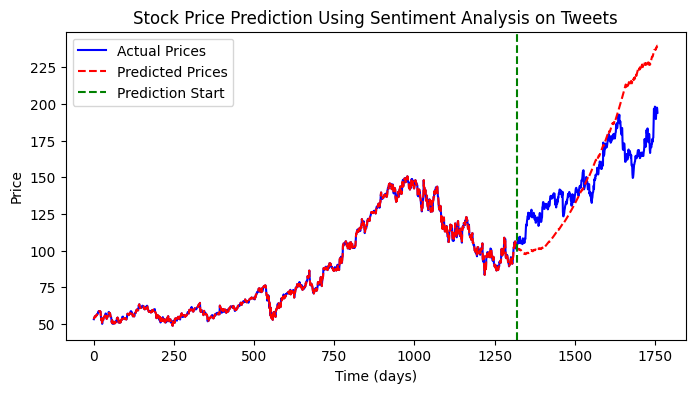

In [ ]:
# Create figure
plt.figure(figsize=(8, 4))

# Plot actual stock prices: solid blue line
plt.plot(closingPrices, label="Actual Prices", color='blue')

# Plot rescaled predicted prices: dashed red line
plt.plot(range(len(sentimentPredictedPrices)), sentimentPredictedPrices, linestyle='--', color='red', label="Predicted Prices")

# Add start of prediction timestamp: vertical green line
plt.axvline(x=splitIndex, color='green', linestyle='--', label="Prediction Start")

# Add a title, legend and labels
plt.title("Stock Price Prediction Using Sentiment Analysis on Tweets")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.legend()

# Display the plot
plt.show()

This plot visualises the comparison between actual stock prices and predicted stock prices, which we generated using sentiment analysis. The blue curve represents the **Actual Prices**, showcasing the historical stock prices across the entire dataset. The red dashed curve  represents the **Predicted Prices**, calculated using tweet sentiment data and extended into future values. A green dashed vertical line marks the **Prediction Start**, indicating the point where future prices begin to be predicted.

Before the prediction start, we use the same dataset for both the red and blue curves: the only discrepancies are after the green line. Beyond this prediction start, the predicted prices display a smoother trend compared to the actual prices. This divergence suggests that the model assumes consistent influence of sentiment on price movements over time and real world stock prices are more volatile than the model captures.

Overall, the sentiment based predictions effectively reflect the general long term trend, with some of the upward and downward movements mildly being captured. However, they fail to recognise short term price fluctuations due to the limited information from the tweets alone. Because of this simplification, we are likely missing critical market dynamics that could influence stock prices.

# Time Series Prediction

Next, we will be using time series prediction on the stock price dataset to estimate future patterns in stock prices.

##**Stock Data**

In [ ]:
# Download historical stock data for chosen stock using yfinance
stockData = yf.download('GOOG', start='2018-01-01', end='2024-12-29')

# Get the closing prices for analysis
closingPrices = stockData['Close'].values

# Add moving average features to dataset
stockData['sevenDayMA'] = stockData['Close'].rolling(7).mean()  # 7-day moving average
stockData['thirtyDayMA'] = stockData['Close'].rolling(30).mean()  # 30-day moving average

# Drop rows with NaN values
stockData.dropna(inplace=True)

# Normalize closing prices between 0 and 1
priceScaler = MinMaxScaler(feature_range=(0, 1))
normalizedClosingPrices = priceScaler.fit_transform(stockData[['Close']].values)

# Normalize moving average features (7-day and 30-day)
maScaler = MinMaxScaler(feature_range=(0, 1))
normalizedMovingAverages = maScaler.fit_transform(stockData[['sevenDayMA', 'thirtyDayMA']].values)

# Combine normalized closing prices and moving averages into single feature set
combinedFeatures = np.hstack((normalizedClosingPrices, normalizedMovingAverages))

# Split data into training and future prediction sets
splitIndex = int(len(combinedFeatures) * 0.75)  # Use 75% of data for training
trainingFeatures = combinedFeatures[:splitIndex]  # Training feature set
trainingClosingPrices = normalizedClosingPrices[:splitIndex]  # Corresponding training target values

[*********************100%***********************]  1 of 1 completed


Like before, historical stock data for Google is fetched using the `yfinance` library from 2018 to 2024. The `Close` prices are extracted as the primary feature for analysis, serving as the foundation for further feature engineering.

To prepare the dataset for time series prediction, a 7 day moving average (`sevenDayMA`) and a 30 day moving average (`thirtyDayMA`) are calculated. These moving averages smooth out daily price fluctuations and provide information into short term and medium term trends. To handle missing values caused by the rolling calculations, rows with insufficient data are removed using `dropna`.

Next, we normalise the features for uniform scaling. Again, the closing prices are scaled to a range of [0, 1] using a `MinMaxScaler`, resulting in `normalizedClosingPrices` and we do the same for the 7 day and 30 day moving averages: they are each normalised with another `MinMaxScaler`, producing `normalizedMovingAverages`. These normalised features are then combined into a feature set by horizontally stacking them with `np.hstack`. This combined dataset includes the original closing prices with the moving average features.

Finally, the dataset is split into training and future prediction sets. We use the same 75% split index to define the training period. The `trainingFeatures` contain the combined feature set for this period period, while `trainingClosingPrices` include the normalised closing prices.


##**Create Time Series**

In [ ]:
# Function to create time series sequences from feature data and target values
def createSequences(data, target, timeSteps):
    sequences, labels = [], []

    # Loop through the dataset to create sequences and labels
    for i in range(len(data) - timeSteps):
        sequences.append(data[i:i + timeSteps])  # Get sequence of correct length
        labels.append(target[i + timeSteps])  # Assign corresponding target value

    # Convert sequences and labels to arrays
    return np.array(sequences), np.array(labels)

# Set number of time steps for training
timeSteps = 100

# Create training sequences, labels via training feature set, target values
xTrain, yTrain = createSequences(trainingFeatures, trainingClosingPrices, timeSteps)

In this section, we create time series sequences from feature data, so our model can learn from temporal patterns.

The function `createSequences` generates sequential data samples from the input dataset via a sliding window. It three main inputs: the feature dataset, the closing prices, and the number of time steps to include in each sequence. For each index in the dataset, we extract a sequence of features over the time steps and assign each a target value. From this, we get two outputs: an array of sequential data samples and an array of corresponding target values.

I have chosen 100 time steps for each sequence. This means that the model can capture meaningful temporal patterns over an extended period.

Using `createSequences`, the training feature set and the normalised closing prices are turned into training data. The resulting `xTrain` contains the sequences of shape `(num_samples, timeSteps, num_features)`, while `yTrain` holds the target closing prices for each sequence.

##**Building and Training Neural Network**

In [ ]:
# Define LSTM sequential model for price prediction
pricePredictionModel = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(timeSteps, xTrain.shape[2]))), # Bidirectional LSTM layer to capture dependencies in both directions
    Dropout(0.3),  # Dropout to prevent overfitting
    LSTM(128, return_sequences=False),  # Second LSTM layer without return sequences, outputs a single vector
    Dropout(0.3),  # Additional dropout to reduce overfitting
    Dense(64, activation='relu'), # Dense layer with ReLU activation for feature learning
    Dense(1)])# Final dense layer for single value output (predicted price)

# Custom loss function, penalise deviations in trends and add regularisation
def customLoss(yTrue, yPred):
    valueLoss = K.mean(K.square(yTrue - yPred))  # Mean Squared Error (MSE) for value prediction
    gradientTrue = yTrue[1:] - yTrue[:-1]  # True trend: differences between consecutive true values
    gradientPred = yPred[1:] - yPred[:-1]  # Predicted trend: differences between consecutive predictions
    trendLoss = K.mean(K.square(gradientTrue - gradientPred))  # Penalise deviations in trend
    return valueLoss + 0.1 * trendLoss + 0.01 * K.sum(K.abs(yPred))  # Total loss with regularisation

# Compile model using Adam optimizer and custom loss function
pricePredictionModel.compile(optimizer=Adam(learning_rate=0.0001), loss=customLoss)

# Define learning rate scheduler to dynamically adjust learning rate during training
def learningRateSchedule(epoch):
    initialLearningRate = 0.001  # Starting learning rate
    decayRate = 0.9  # Learning rate decay factor
    return initialLearningRate * (decayRate ** epoch)

# Create LearningRateScheduler callback with defined schedule
learningRateScheduler = LearningRateScheduler(learningRateSchedule)

# Create EarlyStopping callback: stop training if no improvement to loss
earlyStoppingCallback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reshape training data to match input format required by LSTM model
xTrain = xTrain.reshape(xTrain.shape[0], xTrain.shape[1], xTrain.shape[2])

# Train the model
pricePredictionModel.fit(
    xTrain,  # Input sequences
    yTrain,  # Target values (normalized prices)
    epochs=5,  # Number of epochs for training
    batch_size=32,  # Number of samples per batch
    callbacks=[learningRateScheduler, earlyStoppingCallback],  # Apply learning rate scheduler and early stopping
    verbose=1,  # Display training progress
    validation_split=0.1)  # Use 10% of training data for validation

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 475ms/step - loss: 0.0858 - val_loss: 0.0744 - learning_rate: 0.0010
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 467ms/step - loss: 0.0674 - val_loss: 0.0747 - learning_rate: 9.0000e-04
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - loss: 0.0651 - val_loss: 0.0743 - learning_rate: 8.1000e-04
Epoch 4/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 476ms/step - loss: 0.0669 - val_loss: 0.0742 - learning_rate: 7.2900e-04
Epoch 5/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 465ms/step - loss: 0.0693 - val_loss: 0.0740 - learning_rate: 6.5610e-04


Here, we set up our LSTM neural network to learn time series features.

1. **Model Architecture**: We again use a `Sequential` model with layers stacked linearly. The first layer is a bidirectional LSTM with 128 units and `return_sequences=True`, allowing the model to capture dependencies in both forward and backward directions. The input shape for this layer is `(timeSteps, num_features)`. A dropout layer with a rate of 0.3 follows to reduce overfitting by deactivating 30% of neurons. A second LSTM layer with 128 units and `return_sequences=False` further captures sequential dependencies, outputting a single vector. This is followed by a dense layer with 64 units and ReLU activation for feature learning, and a final dense layer that outputs the predicted price.

2. **Custom Loss Function**: I have created a `customLoss` function to penalise errors in both value and trend predictions. The value loss is computed as the mean squared error (MSE) between actual and predicted prices. The trend loss, also an MSE, measures deviations in predicted price gradients. Additionally, a regularisation term proportional to the sum of absolute predicted values ensures bounded predictions. The total loss combines these components.

3. **Model Compilation**: Again, we use the `Adam` optimiser, configured with a learning rate of 0.0001 for gradient descent. The custom loss function is used alongside this optimiser to evaluate and guide the training process.

4. **Learning Rate Scheduler**: The `learningRateSchedule` function dynamically adjusts the learning rate: starting with an initial rate of 0.001, the learning rate decays by 10% every epoch. This is implemented using a `LearningRateScheduler` callback during the training process.

5. **Early Stopping**: Again, an `EarlyStopping` callback is included to make sure that, if the validation loss does not improve for 5 consecutive epochs, training stops, and the best model weights are restored: this prevents overfitting.

6. **Training**: The training data is reshaped to match the LSTM input format `(num_samples, timeSteps, num_features)`. The model is trained over 5 epochs with a batch size of 32, using a 10% validation split. Both the learning rate scheduler and early stopping callbacks are applied to optimise training.

##**Predicting Stock Prices**

In [ ]:
# Initialize predictions for training
trainingPredictions = np.copy(normalizedClosingPrices[:splitIndex])  # Use normalised training data up to the split index

# Initialize empty list to store future predictions
futurePredictions = []  # Predictions for period after split index

# Generate future predictions by extrapolating from model
lastSequence = combinedFeatures[splitIndex - timeSteps:splitIndex]  # Get last sequence from training data
for i in range(len(closingPrices) - splitIndex):  # Loop through each day in future period
    # Predict next value using trained LSTM model
    nextPrediction = pricePredictionModel.predict(lastSequence.reshape(1, timeSteps, combinedFeatures.shape[1]))
    futurePredictions.append(nextPrediction.flatten()[0])  # Append predicted value to future predictions

    # Check if moving average features are available for next day
    if splitIndex + i < len(normalizedMovingAverages):
        movingAverageData = normalizedMovingAverages[splitIndex + i]  # Use the moving averages for next day
    else:
        # If moving averages not available, use last available values
        movingAverageData = normalizedMovingAverages[-1]

    # Create new row combining predicted value and moving average features
    newRow = np.append(nextPrediction.flatten(), movingAverageData)

    # Update sequence for next prediction, remove the first element, add new row
    lastSequence = np.concatenate((lastSequence[1:], [newRow]), axis=0)

# Rescale future predictions back to original price scale
rescaledFuturePredictions = priceScaler.inverse_transform(np.array(futurePredictions).reshape(-1, 1))

# Combine training predictions with future predictions for plotting
seriesPredictedPrices = np.copy(closingPrices)  # Copy original closing prices
seriesPredictedPrices[splitIndex:] = rescaledFuturePredictions  # Replace future prices with rescaled predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

This section generates future stock price predictions with the trained LSTM model.

Firstly, the `trainingPredictions` are initialised as a copy of the normalised closing prices up to the `splitIndex`. For the period after the `splitIndex`, an empty list named `futurePredictions` is created to store the predicted prices.

Future predictions are extrapolated starting with the `lastSequence`, which is the final sequence from the training data of length `timeSteps` which serves as the initial input for the prediction loop. For each day beyond the `splitIndex`, the LSTM model predicts the next price based on the current `lastSequence`. The predicted price is flattened and appended to the `futurePredictions` list. Moving average data is used to help make the predictions. The input sequence is then updated to make sure the sequence evolves dynamically as predictions progress.

After completing the prediction loop, the normalised predictions stored in `futurePredictions` are rescaled to the original price scale using `priceScaler.inverse_transform`, which are then saved as `rescaledFuturePredictions`.

Finally, the predicted prices are combined in `seriesPredictionPrices` with the original price data to produce a complete series, where before the split index, `closingPrices` is used and after the split index, `rescaledFuturePredictions` is used.


##**Display Results**

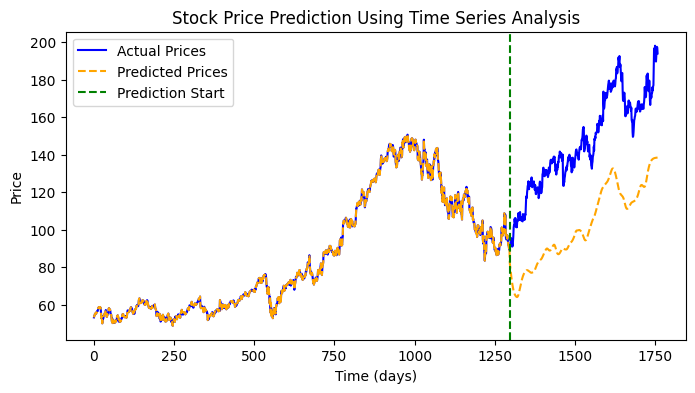

In [ ]:
# Display prediction results
plt.figure(figsize=(8,4))
plt.plot(closingPrices, label="Actual Prices", color='blue')
plt.plot(seriesPredictedPrices, linestyle='--', color='orange', label="Predicted Prices")
plt.axvline(x=splitIndex, color='green', linestyle='--', label="Prediction Start")
plt.title("Stock Price Prediction Using Time Series Analysis")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.legend()
plt.show()

In the prediction period, beyond the prediction start green line, the model's extrapolated predictions begin to diverge from the actual prices. The predicted trend appears smoother and less volatile compared to real stock price. This smoothing effect may be because of the reliance on previous sequences and moving averages as features. These can reduce short term noise. While the predicted prices follow the overall direction of the actual stock prices, this limitation suggests that the LSTM time series prediction method is better suited for identifying long term trends rather than reacting to abrupt market changes.

The inclusion of moving averages as additional features means the model is quite stable, especially further on into the prediction timeline when extrapolation, but the volatility of stock prices do not get captured with this method. Additionally, there is some separation between the actual stock price and target stock price, indicating a high amount of loss.

# Combining Models

Finally, we will combine the results of both methods to produce a prediction which is more precise to the real stock price.

##**Averaging Weights**

In [ ]:
# Define weights for combining predictions
sentimentWeight = 0.7
timeSeriesWeight = 0.3
combinedPredictedPrices = [None] * len(sentimentPredictedPrices)

# Calculate average for each index
for i in range(len(seriesPredictedPrices)):
    combinedPredictedPrices[i] = sentimentWeight*sentimentPredictedPrices[i] + timeSeriesWeight*seriesPredictedPrices.flatten()[i]

Here, we combine predictions from the two different methods: for each day, the corresponding predictions from `sentimentPredictedPrices` (generated through sentiment analysis) and `seriesPredictedPrices` (produced by the LSTM model) are averaged under a weighted average. The combined predictions are stored in `combinedPredictedPrices`, creating a unified prediction, reflective of both strategies.


##**Display Results**

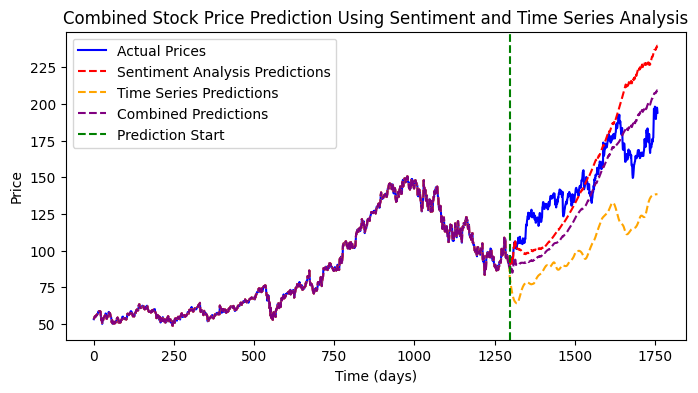

In [ ]:
# Display all prediction results
plt.figure(figsize=(8,4))
plt.plot(closingPrices, label="Actual Prices", color='blue')
plt.plot(range(len(sentimentPredictedPrices)), sentimentPredictedPrices, linestyle='--', color='red', label="Sentiment Analysis Predictions")
plt.plot(seriesPredictedPrices, linestyle='--', color='orange', label="Time Series Predictions")
plt.plot(range(len(combinedPredictedPrices)), combinedPredictedPrices, linestyle='--', color='purple', label="Combined Predictions")
plt.axvline(x=splitIndex, color='green', linestyle='--', label="Prediction Start")
plt.title("Combined Stock Price Prediction Using Sentiment and Time Series Analysis")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.legend()
plt.show()

Here, we compare all three series of prediction results. The combined predictions, the purple dashed line, average the sentiment analysis and timeseries predictionsand balances the strengths of both methods, capturing long term trends while accounting for directional changes.

In the prediction period, after the green line, the combined predictions demonstrate a balanced approach. While significant price deviations are smoothed, the general upward or downward direction is preserved. This compromise reduces overreliance on either sentiment based or historical data driven methods, leading to a more robust forecast.

However, the combined series does not follow the pattern trends as closely, like the time series prediction. Further improvements can include using other factors in this complex system, such as imports and exports data from the company in question and factoring that into the predictions. However, an accurate trajectory has been achieved with this model, indicating a high level of success from this project.

##**Prediction Errors**

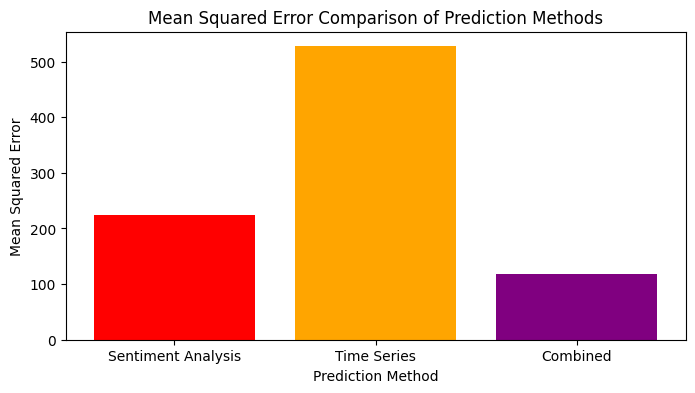

In [ ]:
# Compute mean squared errors for each list
squaredErrorSentiment = np.array([(closing - predicted) ** 2 for closing, predicted in zip(closingPrices, sentimentPredictedPrices)])
squaredErrorTimeSeries = np.array([(closing - predicted) ** 2 for closing, predicted in zip(closingPrices, seriesPredictedPrices)])
squaredErrorCombined = np.array([(closing - predicted) ** 2 for closing, predicted in zip(closingPrices, combinedPredictedPrices)])

mseSentiment = np.mean(squaredErrorSentiment)
mseTimeSeries = np.mean(squaredErrorTimeSeries)
mseCombined = np.mean(squaredErrorCombined)

# Prepare data for plotting
mseValues = [mseSentiment, mseTimeSeries, mseCombined]
labels = ["Sentiment Analysis", "Time Series", "Combined"]

# Plot the bar chart
plt.figure(figsize=(8, 4))
plt.bar(labels, mseValues, color=['red', 'orange', 'purple'])
plt.title("Mean Squared Error Comparison of Prediction Methods")
plt.ylabel("Mean Squared Error")
plt.xlabel("Prediction Method")
plt.show()

The bar chart compares the mean squared error (MSE) of the three prediction methods. The time series predictions result in a higher MSE compared to the combined method and sentiment analysis.

The combined predictions (purple bar) achieved the lowest MSE. This implies that blending the strengths of both approaches provides a more accurate and balanced prediction.
